In [1]:
!pip install invisible_watermark transformers accelerate safetensors diffusers ipywidgets --quiet

In [2]:
# settings
torch_compile = False
cpu_offload = True
channels_last = False
use_refiner = True

from diffusers import DiffusionPipeline
import torch, random, sys

pipe = DiffusionPipeline.from_pretrained(
    'stabilityai/stable-diffusion-xl-base-1.0', 
    torch_dtype = torch.float16, 
    use_safetensors = True, 
    variant = 'fp16')

if use_refiner:
    refiner = DiffusionPipeline.from_pretrained(
        'stabilityai/stable-diffusion-xl-refiner-1.0', 
        text_encoder_2 = pipe.text_encoder_2, 
        vae = pipe.vae, 
        torch_dtype = torch.float16, 
        use_safetensors = True, 
        variant = 'fp16')

    refiner.to('cuda')

if cpu_offload:
    pipe.enable_model_cpu_offload()
else:
    pipe.to('cuda')

if torch_compile and not cpu_offload:
    pipe.unet = torch.compile(
        pipe.unet, 
        mode = 'reduce-overhead', 
        fullgraph = True)
if torch_compile and use_refiner:
    refiner.unet = torch.compile(
        refiner.unet, 
        mode = 'reduce-overhead', 
        fullgraph = True)

if channels_last:
    pipe.unet.to(memory_format = torch.channels_last)
    if use_refiner:
        refiner.unet.to(memory_format = torch.channels_last)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Seed: 4640408535898469025


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

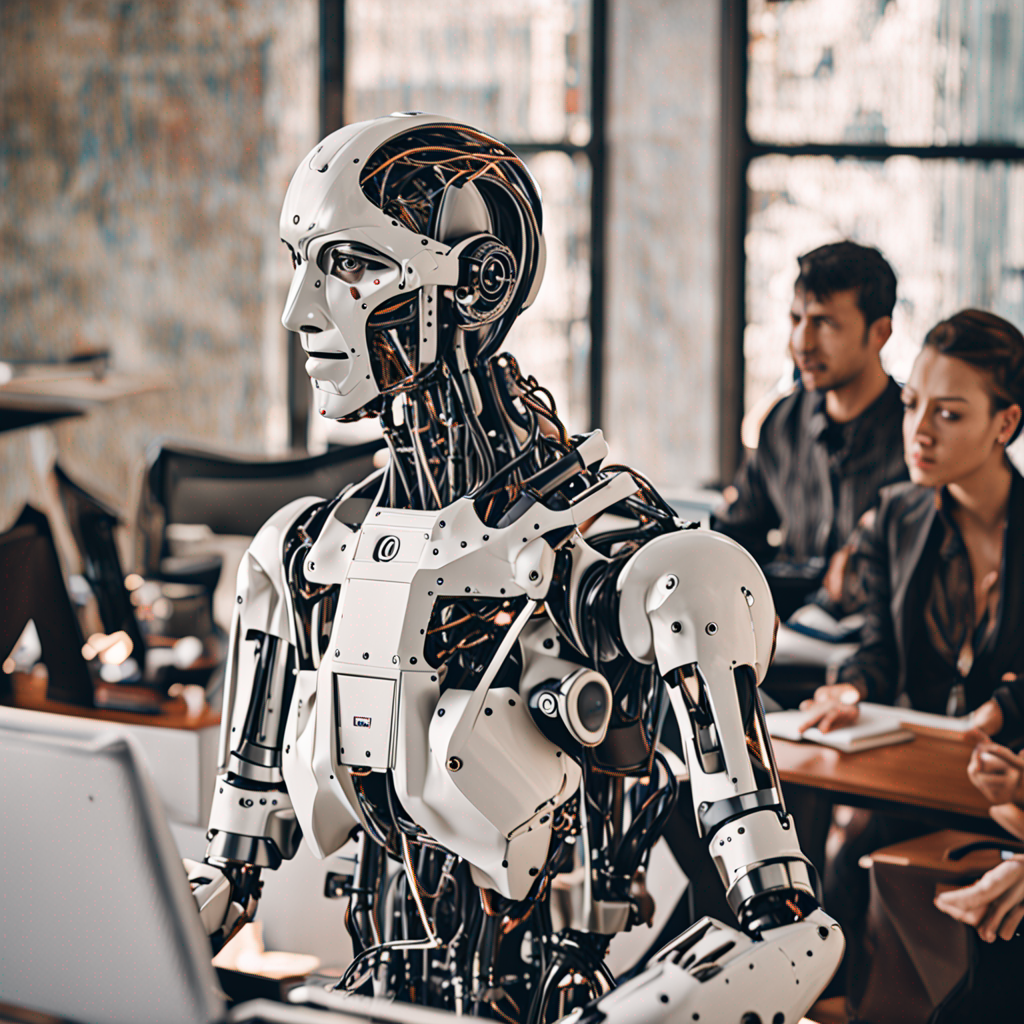

In [3]:
seed = random.randint(0, sys.maxsize) # 2226457081075199629
prompt = 'An MBA class learning about AI'

print('Seed: ' + str(seed))

image = pipe(
    prompt = prompt, 
    output_type = 'latent' if use_refiner else 'pil', 
    generator = torch.Generator('cuda').manual_seed(seed)).images[0]

if use_refiner:
    image = refiner(
        prompt = prompt, 
        generator = torch.Generator('cuda').manual_seed(seed), 
        image = image[None, :]).images[0]

display(image)